In [27]:
from google.colab import drive
drive.mount('/content/drive/')

#### check for gpu
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)

get_available_gpus()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8467600787606840532
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17688803893967416452
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9399430917302209060
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4616636322282035389
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
root = '/content/drive/My Drive/proiectDataScience/photosStructure/'

In [23]:
### load data
### use keras over tf , easier
##16:9 aspect ratio ???
height, width = 512, 290
batch_size = 8
num_classes = 7

image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)    

trainDataSet = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=root,
                                                 target_size=(height, width), 
                                                 subset='training',
                                                 shuffle=True,
                                                 class_mode='categorical')

valDataSet = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=root,
                                                 target_size=(height, width), 
                                                 subset='validation',
                                                 shuffle=True,
                                                 class_mode='categorical')

### test generator
print(trainDataSet.class_indices)
from collections import Counter
counter = Counter(trainDataSet.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

Found 3578 images belonging to 7 classes.
Found 890 images belonging to 7 classes.
{'backview': 0, 'car_features': 1, 'engine': 2, 'frontview': 3, 'interior': 4, 'sideview': 5, 'trunk': 6}
{0: 2.825892857142857, 1: 4.9453125, 2: 20.095238095238095, 3: 2.0, 4: 1.0, 5: 1.5, 6: 18.61764705882353}


In [24]:
### define model
### effNet B6 - 43mil param
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

inputs = Input(shape=(height, width, 3))
model = EfficientNetB6(include_top=False, input_tensor=inputs, weights=None)

model.trainable = True

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)
outputs = Dense(num_classes, activation='relu')(x)

model = tf.keras.Model(inputs=model.inputs, outputs=outputs)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=2e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

#### callbacks

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 290, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 512, 290, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 512, 290, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 291, 3)  0           normalization_3[0][0]            
_______________________________________________________________________________________

In [25]:
history = model.fit(trainDataSet, 
                    validation_data = valDataSet,
                    callbacks=[tensorboard_callback], 
                    epochs=50)

Epoch 1/15
448/448 [==============================] - 1699s 4s/step - loss: 6.7794 - accuracy: 0.2443 - val_loss: 15.6079 - val_accuracy: 0.0169
Epoch 2/15
448/448 [==============================] - 535s 1s/step - loss: 4.8054 - accuracy: 0.3220 - val_loss: 2.8880 - val_accuracy: 0.3506
Epoch 3/15
448/448 [==============================] - 540s 1s/step - loss: 4.3187 - accuracy: 0.3301 - val_loss: 4.3402 - val_accuracy: 0.3337
Epoch 4/15
448/448 [==============================] - 540s 1s/step - loss: 3.8327 - accuracy: 0.4340 - val_loss: 4.3074 - val_accuracy: 0.4371
Epoch 5/15
448/448 [==============================] - 540s 1s/step - loss: 2.4286 - accuracy: 0.5025 - val_loss: 5.8157 - val_accuracy: 0.3674
Epoch 6/15
448/448 [==============================] - 540s 1s/step - loss: 2.5846 - accuracy: 0.5380 - val_loss: 3.1898 - val_accuracy: 0.5573
Epoch 7/15
448/448 [==============================] - 539s 1s/step - loss: 1.8383 - accuracy: 0.6786 - val_loss: 1.6986 - val_accuracy: 0.78

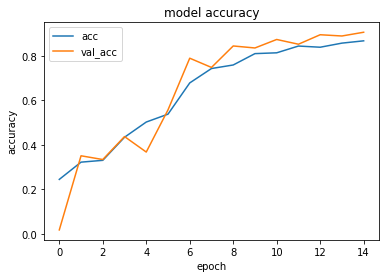

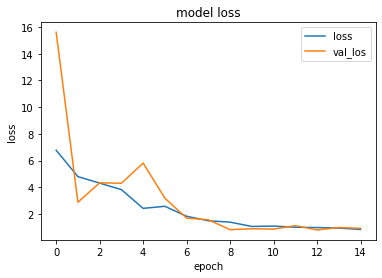

INFO:tensorflow:Assets written to: /content/drive/My Drive/proiectDataScience/saved_model.h5py/assets


In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import save_model
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_los')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

##save the model
#save_model(model, '/content/drive/My Drive/proiectDataScience/')
model.save('/content/drive/My Drive/proiectDataScience/saved_model.h5py')

In [ ]:
########### from a small model we infer all other images
'''
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil

inferDir = '/content/drive/My Drive/proiectDataScience/photos/'

files = glob.glob(inferDir +  '*.jpg')
print(len(files))

labels = trainDataSet.class_names

for f in files:
  img = img_to_array(load_img(f, target_size=(height, width)))
  img = np.array([img])

  res = model.predict(img, batch_size=1)
  res = int(np.argmax(res, axis=1))

  fileName = f.split('/')[-1]

  dst = root + labels[res] + '/' + fileName
  shutil.move(f, dst) 
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
from keras.models import load_model

# load model
model2 = load_model('/content/drive/My Drive/proiectDataScience/saved_model.h5py')
model2.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 290, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 512, 290, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 512, 290, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 291, 3)  0           normalization_3[0][0]            
_______________________________________________________________________________________

In [83]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [77]:
y_true = []
y_pred = []

counter = 0 
for batch_x, batch_y in valDataSet:
  res = model.predict(batch_x, batch_size=8)
  counter += 1

  y_true.extend(np.argmax(batch_y, axis=1))
  y_pred.extend(np.argmax(res, axis=1))
  
  if counter == 111:
    break


In [76]:
print(y_true)
print(y_pred)

[3, 5, 4, 1, 1, 0, 5, 1, 4, 3, 5, 3, 3, 3, 4, 4, 0, 4, 3, 1, 5, 4, 4, 5, 3, 3, 5, 3, 4, 4, 1, 5, 3, 5, 5, 0, 3, 4, 3, 3, 0, 0, 5, 4, 4, 4, 4, 4, 5, 3, 3, 1, 5, 3, 0, 3, 4, 0, 3, 5, 3, 1, 4, 4, 3, 5, 2, 5, 0, 4, 5, 4, 5, 1, 3, 4, 4, 3, 4, 0, 0, 4, 1, 5, 3, 5, 5, 4, 4, 0, 0, 4, 5, 5, 4, 5, 3, 0, 2, 5, 4, 4, 0, 5, 3, 3, 0, 5, 4, 5, 1, 0, 1, 4, 3, 6, 0, 4, 4, 4, 5, 3, 3, 4, 3, 5, 5, 5, 3, 5, 4, 4, 4, 5, 5, 0, 0, 5, 1, 0, 0, 5, 4, 0, 3, 5, 4, 4, 4, 3, 5, 4, 1, 5, 4, 3, 5, 0, 3, 0, 4, 3, 6, 4, 0, 5, 3, 4, 4, 3, 0, 5, 0, 4, 4, 4, 5, 5, 4, 4, 5, 3, 3, 6, 5, 4, 4, 4, 5, 4, 4, 1, 4, 4, 1, 3, 5, 6, 4, 5, 3, 3, 5, 4, 4, 4, 6, 5, 5, 3, 5, 3, 5, 2, 4, 1, 5, 3, 0, 4, 1, 1, 4, 1, 4, 4, 4, 3, 3, 5, 5, 5, 4, 5, 4, 0, 4, 0, 4, 4, 5, 3, 4, 5, 3, 6, 4, 4, 5, 4, 3, 4, 4, 4, 5, 0, 0, 4, 4, 4, 3, 5, 3, 3, 4, 3, 4, 1, 5, 4, 3, 1, 4, 4, 4, 4, 2, 5, 3, 5, 3, 4, 0, 6, 4, 4, 4, 4, 5, 5, 4, 4, 1, 3, 5, 4, 3, 5, 5, 4, 1, 4, 4, 1, 5, 5, 5, 4, 4, 1, 5, 4, 4, 4, 4, 0, 4, 4, 0, 4, 3, 3, 4, 4, 4, 5, 4, 3, 0, 1, 5, 3, 3, 

In [79]:
mat = confusion_matrix(y_true, y_pred)
print(mat)

[[ 99   2   0  10   0   0   0]
 [  4  54   0   1   9   0   0]
 [  1   0   9   1   1   0   0]
 [ 11   2   1 143   0   0   0]
 [  0   1   0   1 323   0   0]
 [  3   1   0   2   3 183   0]
 [ 11   0   2   0   4   0   0]]


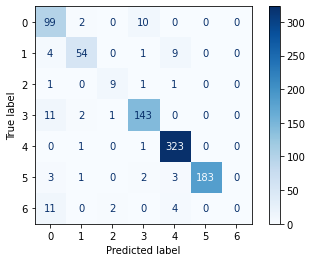

In [94]:
disp = ConfusionMatrixDisplay(confusion_matrix=mat, display_labels=set(valDataSet.labels))
disp = disp.plot(cmap='Blues', values_format='d')

plt.show()